In [0]:
!pip install livelossplot

In [0]:
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLosses

import numpy as np

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Softmax

Using TensorFlow backend.


###  Constants

In [0]:
LOSS = "categorical_crossentropy"
ACC = "categorical_accuracy"
TEST_RATIO = 0.15
VAL_RATIO = 0.1

### Data preparation

In [0]:
iris = datasets.load_iris()

In [0]:
X = preprocessing.scale(iris.data)
enc = preprocessing.OneHotEncoder()
y = enc.fit_transform(iris.target.reshape(-1, 1))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VAL_RATIO)

### Visualization

In [0]:
liveplot = PlotLosses(skip_first=0)

### Model

In [0]:
class Model():
    def __init__(self,
                 in_shape: int,
                 classes: int,
                 std: float = 0.1,
                 weights: list = None,
                 *args,
                 **kwargs):
      self.in_shape = in_shape
      self.classes = classes
      self.std = std
      self.__init_net()
      self.net.compile(*args, **kwargs)

      if weights is None:
        self.__init_net_weights()
      else:
        self.set_net_weights(weights)
      
    def __init_net(self) -> Sequential:
      net = Sequential()
      net.add(Dense(32, activation='relu', input_shape = (self.in_shape,)))
      net.add(Dense(self.classes, activation='softmax'))
      self.net = net

    def __init_net_weights(self):
      for layer in self.net.layers:
        shape = layer.get_weights()[0].shape
        layer.set_weights([np.random.normal(0, self.std, size = layer.get_weights()[0].shape), 
                           np.random.normal(0, self.std, size = layer.get_weights()[1].shape)])
      
    def evaluate(self, X, y, verbose):
      return self.net.evaluate(X, y, verbose=verbose)

    def fit(self, X, y, *args, **kwargs):
      return self.net.fit(X, y, *args, **kwargs)

    def get_net_weights(self) -> list:
      return [layer.get_weights() for layer in self.net.layers]

    def set_net_weights(self, weights: list):
      for layer, weight in zip(self.net.layers, weights):
          layer.set_weights(weight)

    def get_new_net_weights(self) -> list:
      new_net_weights = []
      
      for weights in self.get_net_weights():
        new_weights_0 = []
        for layer in weights[0]:
          new_weights_0.append(np.array(list(map(lambda weight: np.random.normal(weight, self.std), layer))))
        new_weights_1 = []
        for weight in weights[1]:
          new_weights_1.append(np.random.normal(weight, self.std))
        
        new_net_weights.append([np.array(new_weights_0), np.array(new_weights_1)])
      return new_net_weights

In [0]:
def simulated_annealing_optimization(model, X, y, T, cooled_T, annealing_rate):    
    # repeat until cooled down
    while (T > cooled_T):

        current_net_weights = model.get_net_weights()
        current_loss, _ = model.evaluate(X_train, y_train, verbose=0)
        
        new_net_weights = model.get_new_net_weights()
        model.set_net_weights(new_net_weights)
        new_loss, _ = model.evaluate(X_train, y_train, verbose=0)

        if not (np.random.uniform() <= np.exp((current_loss - new_loss) / T)):
            model.set_net_weights(current_net_weights)

        T *= annealing_rate
        
        loss, acc = model.evaluate(X_train, y_train, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

        liveplot.update({
            'accuracy': acc,
            'val_accuracy': val_acc,
            'loss': loss,
            'val_loss': val_loss
        })
        liveplot.draw()

### Simulated Annealing as an optimization method

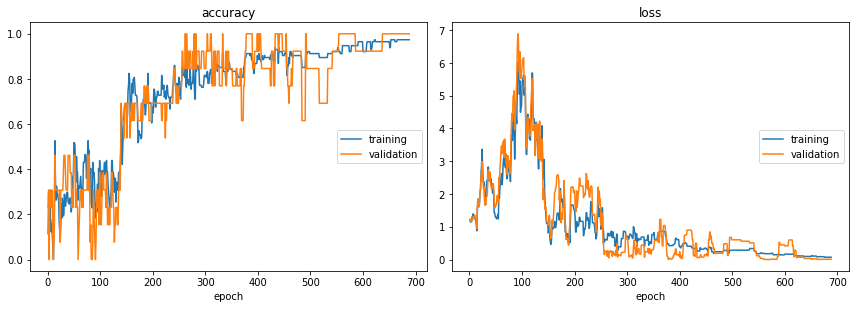

accuracy:
training   (min:    0.000, max:    0.974, cur:    0.974)
validation (min:    0.000, max:    1.000, cur:    1.000)

loss:
training   (min:    0.071, max:    6.031, cur:    0.071)
validation (min:    0.001, max:    6.885, cur:    0.009)


In [0]:
model = Model(X.shape[1], y.shape[1], std=0.1, loss=LOSS, metrics=[ACC])
simulated_annealing_optimization(model, X_train, y_train, 5, 0.005, 0.99)

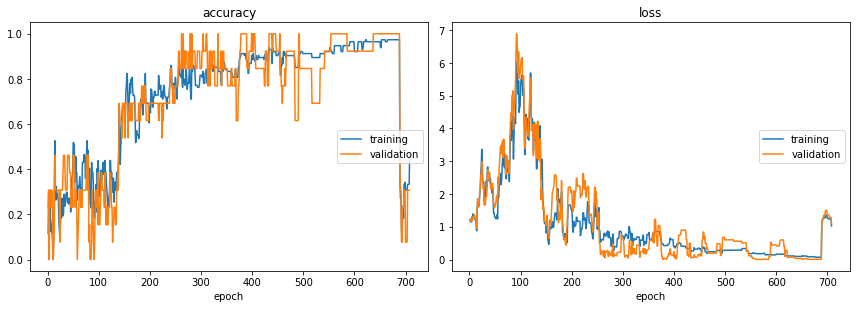

accuracy:
training   (min:    0.000, max:    0.974, cur:    0.465)
validation (min:    0.000, max:    1.000, cur:    0.308)

loss:
training   (min:    0.071, max:    6.031, cur:    1.024)
validation (min:    0.001, max:    6.885, cur:    1.091)


In [0]:
model = Model(X.shape[1], y.shape[1], std=0.1, loss=LOSS, metrics=[ACC])
simulated_annealing_optimization(model, X_train, y_train, 5, 0.005, 0.7)

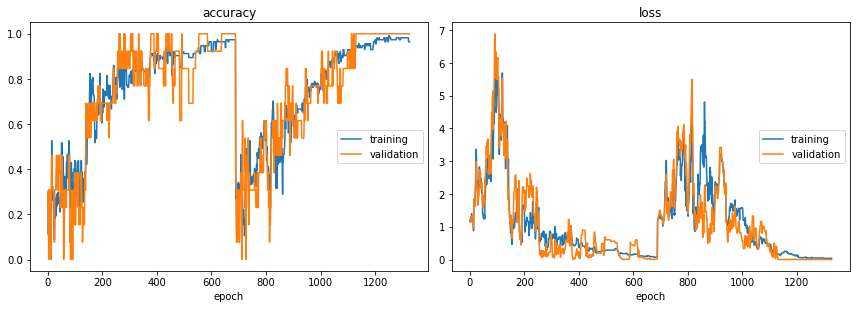

accuracy:
training   (min:    0.000, max:    0.991, cur:    0.965)
validation (min:    0.000, max:    1.000, cur:    1.000)

loss:
training   (min:    0.032, max:    6.031, cur:    0.039)
validation (min:    0.000, max:    6.885, cur:    0.000)


In [0]:
model = Model(X.shape[1], y.shape[1], std=0.1, loss=LOSS, metrics=[ACC])
simulated_annealing_optimization(model, X_train, y_train, 2.5, 0.005, 0.99)

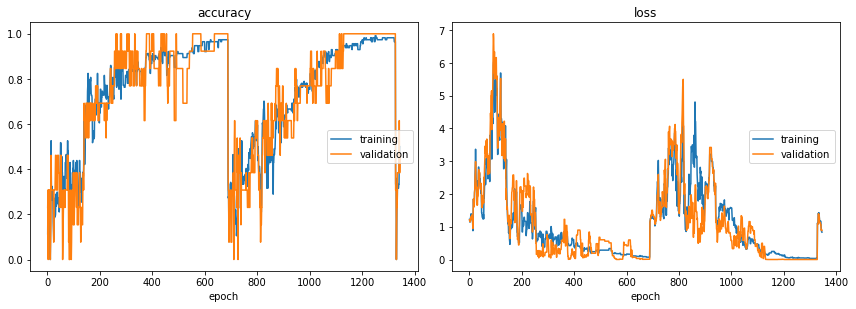

accuracy:
training   (min:    0.000, max:    0.991, cur:    0.500)
validation (min:    0.000, max:    1.000, cur:    0.462)

loss:
training   (min:    0.032, max:    6.031, cur:    0.833)
validation (min:    0.000, max:    6.885, cur:    0.884)


In [0]:
model = Model(X.shape[1], y.shape[1], std=0.1, loss=LOSS, metrics=[ACC])
simulated_annealing_optimization(model, X_train, y_train, 2.5, 0.005, 0.7)

### SGD as an optimization method

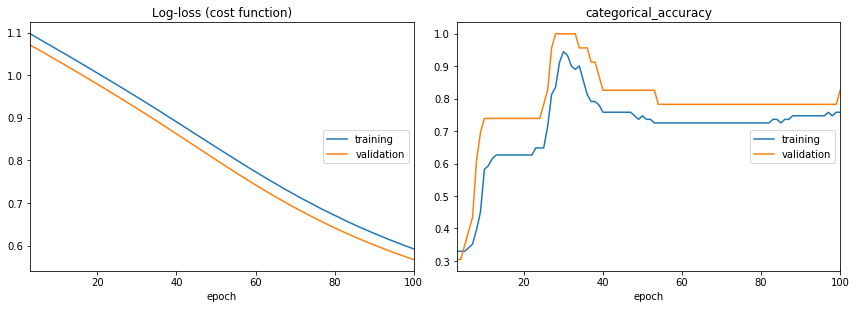

Log-loss (cost function):
training   (min:    0.592, max:    1.108, cur:    0.592)
validation (min:    0.567, max:    1.081, cur:    0.567)

categorical_accuracy:
training   (min:    0.319, max:    0.945, cur:    0.758)
validation (min:    0.304, max:    1.000, cur:    0.826)


In [0]:
model = Model(X.shape[1], y.shape[1], optimizer='sgd', loss=LOSS, metrics=[ACC])
model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[PlotLossesCallback()])